# **Introduction**

Optical character recognition is an old "AI" and image-processing task.  What it involves is taking a photograph or scan of a piece of text (printed or handwritten) and turning the characters (as images) into character codes on the computer that therefore allow the text to be edited, indexed, etc.  A key part of that process is identifying where the characters actually are, especially if the characters are mixed among other non-writing, such as images of objects or people.

In this assignment, you will take images from a Chinese image database with annotations that indicate where the Chinese characters are, and you will train a model that takes test images, and superimposes upon them a visualization (of your choosing, e.g., a "heat map") of the likelihood that a pixel is close to or part of a valid Chinese character.  The image database contains annotations of "bounding boxes", coordinates of the corners of a box that contains a single Chinese character.  In a sense, this assignment asks you to detect the bounding boxes in test images without the annotation, but a softer version of this: simply to provide the probability, for each pixel, whether that pixel was part of a bounding box containing a Chinese character.  Then, you are to (1) superimpose upon the image a pixel-based map of likelihoods of where the bounding boxes ought to be and (2) apply an evaluation statistic.

This assignment grants you a lot of freedom in how you organize your code and set up the task overall.  Because of the degree of freedom it involves, it will mostly be graded on our evaluation of the effort put into the solution.  An actual high success at the task is not a requirement to get a high grade.  However, you will have to report in detail, in your own format, what you did, why you did it, how to run it -- it must run on mltgpu, be implemented in Python using PyTorch, and make use of the GPUs -- and how to apply it easily to our own test images.

You will have almost a month to do this assignment, even though it is worth only 30% of your grade.  Another assignment with 30% will be given out for the last/remaining two weeks of the study period.   These time periods are coextensive with that of the project, but we expect you to be able to schedule your time well enough to put in an effort at both. This assignment is officially due at **23:59 on 2021 October 18**. There are 30 points on this assignment, and a maximum of 20 bonus points.

# **The data**

The source of the task is here: https://ctwdataset.github.io/ (Links to an external site.) They have example images and an example of a baseline task that is much more advanced than what we are doing, but it will give you an idea of the data format, particularly the metadata.  Pay attention especially to the "Annotation format" section of this page: https://ctwdataset.github.io/tutorial/1-basics.html (Links to an external site.)

The metadata and a small sample of the whole image dataset is available at /scratch/lt2326-h21/a1 on mltgpu. The metadata is in json format.  info.json contains information about every image file.  We will unzip only a minority of the original training image files.  train.jsonl is a list of json entities, one per line (that have to be parsed with the json package each separately) that correspond to the files in info.json.  This contains the bounding box information, as well as other information for the original challenge on the web.  See the "Annotation format" section mentioned on the dataset web page linked above.

# **Part 1: data preparation (7 points)**

The image files are in /scratch/lt2326-h21/a1/images on mltgpu. They are in jpg format.  The code that you write for this part of the project should:

- Use the info.json file to figure out what files are in the training set.  You will just use the official training data for everything.  Remember that you will only see a small minority of training examples in the images directory, for space reasons.
- Divide up the official training data files into your own training, validation, and test datasets depending on your own preferences. You can choose to use fewer files than the maximum available if you run into problems with memory and so on (but first make sure your implementation is reasonably efficient).
- Find the corresponding bounding box information in train.jsonl for each image.

You can represent the data in any way you like, but remember that it will become a numpy array for processing and a torch tensor for training.  Remember also that the classes are defined by pixel: for each pixel, you will eventually have a set of features (e.g. colour values), and a binary class corresponding to whether the pixel was in a Chinese character bounding box or not (note that there are non-Chinese characters in the set -- see the annotation instructions).  You are allowed to reduce the dimensionality of the images for processing, but consider using a pooling and/or upsampling technique in Part 2 of this assignment to accomplish this goal. 

Describe the choices you made and the challenges you found in your report.

In [84]:
#imports

import json
import numpy as np
import pandas as pd
import random
from torch import nn
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.path as mplpath
from skimage import io

#device
device = torch.device('cuda:3')

In [2]:
#paths

images_directory = "/scratch/lt2326-h21/a1/images"
train_json = "/scratch/lt2326-h21/a1/train.jsonl"
info_json = "/scratch/lt2326-h21/a1/info.json"


#opening files and images

with open(train_json) as trainfile:
    train_data = [json.loads(x) for x in trainfile]

with open(info_json) as infofile:
    info_data = json.load(infofile)

In [3]:
#figure out what files are in the training set

selection = ['train']
filtered = list(filter(lambda i: i[0] in selection, info_data.items()))
filenames = [d['file_name'] for d in filtered[0][1]]

iiiimages = os.listdir(images_directory)

my_images = []
for n in iiiimages:
    if n in filenames:
        my_images.append(n.replace('.jpg', ''))

In [4]:
#getting all usable files

files = []
for image in train_data:
    if image['image_id'] in my_images:
        files.append(image)

In [5]:
#find the corresponding bounding box information in train.jsonl for each image

def chinese(images):
    ch_dict = {}
    ch_list = []
    
    for i in images:
        ch_dict[i['image_id']] = {'polygons' : []}
        poly_list = []
        for annotation in i['annotations']:
            for an in annotation:
                if an['is_chinese'] == True:
                    ch_dict[i['image_id']]['polygons'].append(an['polygon'])
                    poly_list.append(an['polygon'])
        ch_list.append((i['image_id'], poly_list))
                    
    return ch_list

chinese_list = chinese(files)

In [7]:
def img_to_tensor(path_to_img):
    
    img = io.imread(path_to_img)

    img = torch.tensor(img).float()
    
    return img #img

In [6]:
from skimage import transform

#Image to tensor, resized to 300 x 300
def img_to_tensor_small(path_to_img):
    
    img = io.imread(path_to_img)

    img = transform.resize(img, (300, 300))
    
    img = torch.tensor(img).float()
    
    return img #img

In [8]:
def get_truth(polygons_list):
    
    grr = [[[a, b] for b in list(range(2048))] for a in list(range(2048))]
    grid = np.array(grr)
    grid.shape = (4194304, 2)
    
    p = [pol for pol in polygons_list]

    truth_array = np.zeros(4194304)
    for x in p:
        p2 = mplpath.Path(x)
        truth = np.asarray(p2.contains_points(grid), int)
        truth_array = np.maximum(truth_array, truth)
    
    t_tensor = torch.from_numpy(truth_array)
    
    truth_tensor = torch.tensor(t_tensor).type(torch.LongTensor) #.to(device)
    
    return truth_tensor

In [9]:
training_real, validation_real, test_real = np.split(chinese_list, [int(len(files)*0.8), int(len(files)*0.9)])

/usr/local/lib64/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
import time
from joblib import Parallel, delayed

def process_images_in_parallel(image):
    return (img_to_tensor_small(images_directory + "/" + image[0] + ".jpg"),  ##img_to_tensor for model1
            get_truth(image[1])) 

In [10]:
start = time.time()
processed_data = Parallel(n_jobs = 10)(delayed(process_images_in_parallel)(image) for image in training_real)
end = time.time()

print("Processing data took", round(end-start, 0), "seconds")

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2195007/2728341155.py:17: UserWarning

Processing data took 1228.0 seconds


In [11]:
start = time.time()
processed_data_test = Parallel(n_jobs = 10)(delayed(process_images_in_parallel)(image) for image in test_real)
end = time.time()

print("Processing data took", round(end-start, 0), "seconds")

/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning

/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning

/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_2200194/2728341155.py:17: UserWarning

Processing data took 140.0 seconds


# **Part 2: the models (10 points)**

In this part, you will implement two substantially different model archictectures, that both take your representation of the images as training input and both take your representation of the bounding boxes as objective (HINT: the binary classification of pixels as belonging to a bounding box or not).  They will save the trained models to files so that they can be loaded and tested later. The output of the models will be a "soft binary" -- the probability of each pixel being inside a bounding box, from 0 to 1.  Consider examining some of the training data before designing your architectures.

You have a large grant of freedom as to what these model architectures will look like (remember: grading is on a "reasonable effort" basis).  There's a high chance (HINT) that they will both use one or more convolutional layers, among other things.  Describe the models and the motivations for the architecture in your report.

In [13]:
#model imports
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.optim as optim
from torch.utils.data import DataLoader

In [12]:
#parameters
learning_rate = 0.001
epochs = 3

In [13]:
dataloader_train = DataLoader(processed_data, shuffle=True, batch_size=2)

In [94]:
#MODEL 1
#LeNet
#CONV => RELU => POOL * 2 => FC => RELU => FC => SOFTMAX

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        
        #CONV => RELU => POOL 1.0
        self.conv1 = Conv2d(in_channels=3, out_channels=3, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(5, 5), stride=(1, 1))
        
        #CONV => RELU => POOL 2.0
        self.conv2 = Conv2d(in_channels=3, out_channels=3, kernel_size=(5, 5)) 
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(5, 5), stride=(1, 1))

        #FC => RELU
        self.fc1 = Linear(in_features=241968, out_features=500)
        self.relu3 = ReLU()
        
        #softmax classifier
        self.fc2 = Linear(in_features=500, out_features=2)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x):
        
        #CONV => RELU => POOL 1.0
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        #CONV => RELU => POOL 2.0
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        #FC => RELU
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        
        #softmax classifier
        x = self.fc2(x)
        out = self.sigmoid(x)

        return out

In [15]:
model1 = Model1().to(device)

model1.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
batch_size = 2

for e in range(epochs):
    total_loss = 0
    for i, (image,truth) in enumerate(dataloader_train):

        image, truth = image.to(device), truth.to(device)
    
        reshaping_x2 = image.reshape(len(image), 3, 300, 300)
        
        out = model1(reshaping_x2)

        out = out.reshape(len(image), 2, 1)
        blabla = torch.nn.Upsample(size=2048*2048)
        out = blabla(out)
        
        loss = loss_function(out, truth)
        total_loss += loss.item()
        print(total_loss/(i+1), end='\r')
        
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()
        
    print()
    
torch.save(model1, 'model1_chinese_SMALLIMGS.pt')

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.31924249857840453
0.31812289692241064
0.31812289648154785


In [13]:
#parameters
learning_rate = 0.001
epochs = 3

In [75]:
#MODEL2
#VGG-16

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        self.conv1 =  nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv2 =  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv3 =  nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv4 =  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()

        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


        self.conv5 =  nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()

        self.conv6 =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()

        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv7 =  nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn7 = nn.BatchNorm2d(512)
        self.relu7 = nn.ReLU()

        self.conv8 =  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU()

        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


        self.conv9 =  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn9 = nn.BatchNorm2d(512)
        self.relu9 = nn.ReLU()

        self.conv10 =  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.batchn10 = nn.BatchNorm2d(512)
        self.relu10 = nn.ReLU()

        self.maxpool5 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.lin1 = nn.Linear(41472, 2048)
        self.relufin = nn.ReLU(True)
        self.dropfin = nn.Dropout(p=0.65)
        self.lin2 = nn.Linear(2048, 1024)
        self.relufin2 = nn.ReLU(True)
        self.dropfin2 = nn.Dropout(p=0.65)
        self.linfin = nn.Linear(1024, 625)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        # bloc1
        x = self.conv1(x)
        x = self.batchn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.batchn2(x)
        x = self.relu2(x)

        x = self.maxpool1(x)

        # bloc2
        x = self.conv3(x)
        x = self.batchn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.batchn4(x)
        x = self.relu4(x)

        x = self.maxpool2(x)

        # bloc3
        x = self.conv5(x)
        x = self.batchn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.batchn6(x)
        x = self.relu6(x)

        x = self.maxpool3(x)

        # bloc4
        x = self.conv7(x)
        x = self.batchn7(x)
        x = self.relu7(x)

        x = self.conv8(x)
        x = self.batchn8(x)
        x = self.relu8(x)

        x = self.maxpool4(x)

        # bloc5
        x = self.conv9(x)
        x = self.batchn9(x)
        x = self.relu9(x)

        x = self.conv10(x)
        x = self.batchn10(x)
        x = self.relu10(x)

        x = self.maxpool5(x)

        x = x.reshape(x.shape[0], -1).contiguous()

        # classifier     
        x = self.lin1(x)
        x = self.relufin(x)
        x = self.dropfin(x)
        x = self.lin2(x)
        x = self.relufin2(x)
        x = self.dropfin2(x)
        x = self.linfin(x)

        out = self.sigmoid(x)

        return out


In [25]:
#VGG-16
model2 = Model2().to(device)

model2.train()

loss_function = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
batch_size = 2


for e in range(epochs):
    total_loss = 0
    for i, (image,truth) in enumerate(dataloader_train):

        image, truth = image.to(device), truth.to(torch.float32).to(device)
    
        perm_image = image.permute(0, 3, 1, 2)

        out = model2(perm_image)
        out = out.reshape(len(out), 25, 25, 1)

        out = out.permute((0, 3, 1, 2))
        
        blabla = torch.nn.Upsample((2048, 2048))
        out = blabla(out)
        
        out = out.permute((0, 2, 3, 1))
        out = out.reshape(len(out), 4194304)

        loss = loss_function(out, truth)
        total_loss += loss.item()
        print(total_loss/(i+1), end='\r')
        
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()
        
    print()
    
torch.save(model2, 'model2_chinese.pt')

0.50431349076132275
0.49418166965334376
0.49738734464585427


# **Part 3: testing and evaluation (13 points)**

You can use your test data by feeding the test images forward through the models. The output of the models will be pixel maps of the probability of a particular pixel being inside a bounding box.  These will be compared outside the model to the test data's bounding boxes.  You can use a number of different evaluation strategies -- one of them being to choose a probability threshold to decide whether a pixel is inside the bounding box or not, and then take recall/precision/X11/accuracy. Another one is to report it in terms of error, such as mean squared error. Even given your architectural choices, you will likely have hyperparameters to tune.  Describe the progress of your training and testing, with graphs if necessary, in your report.

It should also be possible to examine the effects of applying the model to individual images.  Make it possible to visually represent the pixel/bounding box probabilities superimposed on the original images.  Examine some of the images to conduct a qualitative error analysis of your trained models. Include this analysis in your report.

In [14]:
dataloader_test = DataLoader(processed_data_test, shuffle=True, batch_size=2)

In [78]:
model1 = torch.load("model1_chinese_SMALLIMGS.pt")

In [19]:
model1.eval()

MSE = nn.MSELoss()

total_MSE = 0

for i, (image,truth) in enumerate(dataloader_test):

    image, truth = image.to(device), truth.to(device)

    reshaping_x2 = image.reshape(len(image), 3, 300, 300)

    out = model1(reshaping_x2)

    out = out.reshape(len(image), 2, 1)
    blabla = torch.nn.Upsample(size=2048*2048)
    out = blabla(out)

    #Mean Squared Error
    mse_loss = MSE(out, truth.float())
    mse_loss.backward()
    total_MSE += mse_loss.item()

print("Mean squared error: ", total_MSE)

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib64/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2, 4194304])) that is different to the input size (torch.Size([2, 2, 4194304])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Mean squared error:  21.504563808441162


/usr/local/lib64/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 4194304])) that is different to the input size (torch.Size([1, 2, 4194304])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [79]:
model2 = torch.load("model2_chinese.pt")

In [31]:
model2.eval()

MSE = nn.MSELoss()

total_MSE = 0

for i, (image,truth) in enumerate(dataloader_train):

    image, truth = image.to(device), truth.to(torch.float32).to(device)

    perm_image = image.permute(0, 3, 1, 2)

    out = model2(perm_image)
    out = out.reshape(len(out), 25, 25, 1)

    out = out.permute((0, 3, 1, 2))

    blabla = torch.nn.Upsample((2048, 2048))
    out = blabla(out)

    out = out.permute((0, 2, 3, 1))
    out = out.reshape(len(out), 4194304)

    #Mean Squared Error
    mse_loss = MSE(out, truth.float())
    mse_loss.backward()
    total_MSE += mse_loss.item()
    
print("Mean squared error: ", total_MSE)

Mean squared error:  1.643059253692627


In [20]:
#Examining some of the images

import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import matplotlib.path as mppath

In [81]:
def examine_1(model, device):
    image = img_to_tensor_small(images_directory + "/" + random.choice(my_images) + ".jpg")
    to_print = mpimage.imread(images_directory + "/" + random.choice(my_images) + ".jpg")
    image = image.reshape(3, 300, 300).unsqueeze(0).float()
    image = image.to(device)
    
    with torch.no_grad():
        modelled = model(image)
    
    u = torch.nn.Upsample(size=2048*2048)
    out = modelled.reshape(len(image), 1, 2)
    out = u(out)
    out = out.reshape(2048, 2048)
    out = out.squeeze()
    letstrysomething = np.array(out.cpu())

    plt.figure()
    plt.imshow(to_print)
    plt.imshow(letstrysomething, alpha = 0.5)

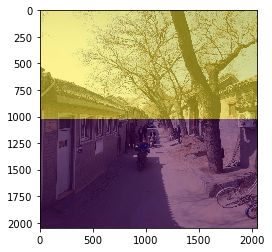

In [82]:
examine_1(model1, device)

In [86]:
def examine_2(model, device):
    image = img_to_tensor_small(images_directory + "/" + random.choice(my_images) + ".jpg")
    to_print = mpimage.imread(images_directory + "/" + random.choice(my_images) + ".jpg")
    image = image.reshape(3, 300, 300).unsqueeze(0).float()
    image = image.to(device)
    
    with torch.no_grad():
        modelled = model(image)
    
    u = torch.nn.Upsample(size=2048*2048)
    out = modelled.reshape(len(image), 1, 625)
    out = u(out)
    out = out.reshape(2048, 2048)
    out = out.squeeze()
    letstrysomething = np.array(out.cpu())

    plt.figure()
    plt.imshow(to_print)
    plt.imshow(letstrysomething, alpha = 0.5)

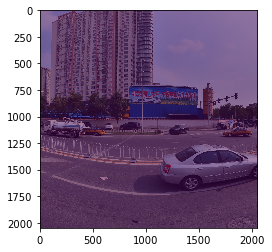

In [92]:
examine_2(model2, device)